#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [20]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 15):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df.head(5)

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [3]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [4]:
data.head(5)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [8]:
data.shape

(5881, 563)

In [12]:
data.info(max_cols=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB


In [11]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [5]:
target = 'Activity'

In [6]:
data[target].value_counts()

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

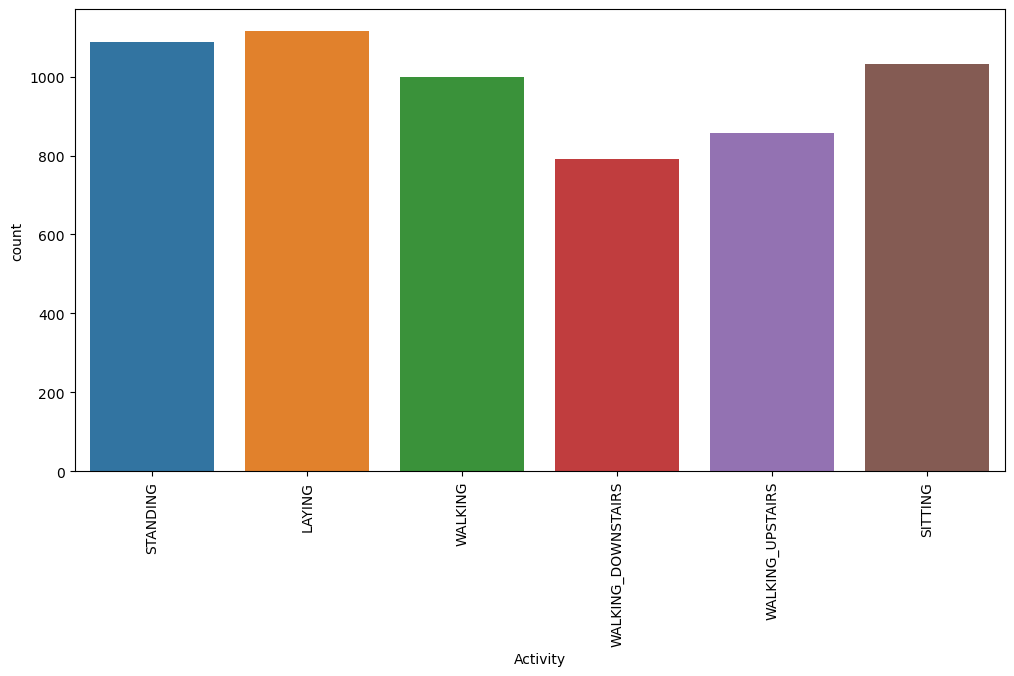

In [7]:
plt.figure(figsize=(12,6))
axis=sns.countplot(x="Activity",data=data)
plt.xticks(x=data['Activity'],rotation='vertical')
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [8]:
features.groupby(['feature_name','sensor'])[['sensor']].count().unstack()

sensor                                    \
sensor                                angle fBodyAcc fBodyAccJerk fBodyAccMag   
feature_name                                                                    
angle(X,gravityMean)                    1.0      NaN          NaN         NaN   
angle(Y,gravityMean)                    1.0      NaN          NaN         NaN   
angle(Z,gravityMean)                    1.0      NaN          NaN         NaN   
angle(tBodyAccJerkMean),gravityMean)    1.0      NaN          NaN         NaN   
angle(tBodyAccMean,gravity)             1.0      NaN          NaN         NaN   
...                                     ...      ...          ...         ...   
tGravityAccMag-max()                    NaN      NaN          NaN         NaN   
tGravityAccMag-mean()                   NaN      NaN          NaN         NaN   
tGravityAccMag-min()                    NaN      NaN          NaN         NaN   
tGravityAccMag-sma()                    NaN      NaN          NaN         NaN   
tGravityAccMag-std()                    NaN      NaN          NaN         NaN   

                                                                               \
sensor                               fBodyBodyAccJerkMag fBodyBodyGyroJerkMag   
feature_name                                                                    
angle(X,gravityMean)                                 NaN                  NaN   
angle(Y,gravityMean)                                 NaN                  NaN   
angle(Z,gravityMean)                                 NaN                  NaN   
angle(tBodyAccJerkMean),gravityMean)                 NaN                  NaN   
angle(tBodyAccMean,gravity)                          NaN                  NaN   
...                                                  ...                  ...   
tGravityAccMag-max()                                 NaN                  NaN   
tGravityAccMag-mean()                                NaN                  NaN   
tGravityAccMag-min()                                 NaN                  NaN   
tGravityAccMag-sma()                                 NaN                  NaN   
tGravityAccMag-std()                                 NaN                  NaN   

                                                                          \
sensor                               fBodyBodyGyroMag fBodyGyro tBodyAcc   
feature_name                                                               
angle(X,gravityMean)                              NaN       NaN      NaN   
angle(Y,gravityMean)                              NaN       NaN      NaN   
angle(Z,gravityMean)                              NaN       NaN      NaN   
angle(tBodyAccJerkMean),gravityMean)              NaN       NaN      NaN   
angle(tBodyAccMean,gravity)                       NaN       NaN      NaN   
...                                               ...       ...      ...   
tGravityAccMag-max()                              NaN       NaN      NaN   
tGravityAccMag-mean()                             NaN       NaN      NaN   
tGravityAccMag-min()                              NaN       NaN      NaN   
tGravityAccMag-sma()                              NaN       NaN      NaN   
tGravityAccMag-std()                              NaN       NaN      NaN   

                                                                               \
sensor                               tBodyAccJerk tBodyAccJerkMag tBodyAccMag   
feature_name                                                                    
angle(X,gravityMean)                          NaN             NaN         NaN   
angle(Y,gravityMean)                          NaN             NaN         NaN   
angle(Z,gravityMean)                          NaN             NaN         NaN   
angle(tBodyAccJerkMean),gravityMean)          NaN             NaN         NaN   
angle(tBodyAccMean,gravity)                   NaN             NaN         NaN   
...                                           ...     

In [9]:
features.groupby(['feature_name','agg'])[['agg']].count().unstack()

agg                                 \
agg                                     X    Y    Z arCoeff() arCoeff()1   
feature_name                                                               
angle(X,gravityMean)                  1.0  NaN  NaN       NaN        NaN   
angle(Y,gravityMean)                  NaN  1.0  NaN       NaN        NaN   
angle(Z,gravityMean)                  NaN  NaN  1.0       NaN        NaN   
angle(tBodyAccJerkMean),gravityMean)  NaN  NaN  NaN       NaN        NaN   
angle(tBodyAccMean,gravity)           NaN  NaN  NaN       NaN        NaN   
...                                   ...  ...  ...       ...        ...   
tGravityAccMag-max()                  NaN  NaN  NaN       NaN        NaN   
tGravityAccMag-mean()                 NaN  NaN  NaN       NaN        NaN   
tGravityAccMag-min()                  NaN  NaN  NaN       NaN        NaN   
tGravityAccMag-sma()                  NaN  NaN  NaN       NaN        NaN   
tGravityAccMag-std()                  NaN  NaN  NaN       NaN        NaN   

                                                                       \
agg                                  arCoeff()2 arCoeff()3 arCoeff()4   
feature_name                                                            
angle(X,gravityMean)                        NaN        NaN        NaN   
angle(Y,gravityMean)                        NaN        NaN        NaN   
angle(Z,gravityMean)                        NaN        NaN        NaN   
angle(tBodyAccJerkMean),gravityMean)        NaN        NaN        NaN   
angle(tBodyAccMean,gravity)                 NaN        NaN        NaN   
...                                         ...        ...        ...   
tGravityAccMag-max()                        NaN        NaN        NaN   
tGravityAccMag-mean()                       NaN        NaN        NaN   
tGravityAccMag-min()                        NaN        NaN        NaN   
tGravityAccMag-sma()                        NaN        NaN        NaN   
tGravityAccMag-std()                        NaN        NaN        NaN   

                                                                  ...         \
agg                                  bandsEnergy() correlation()  ... mean()   
feature_name                                                      ...          
angle(X,gravityMean)                           NaN           NaN  ...    NaN   
angle(Y,gravityMean)                           NaN           NaN  ...    NaN   
angle(Z,gravityMean)                           NaN           NaN  ...    NaN   
angle(tBodyAccJerkMean),gravityMean)           NaN           NaN  ...    NaN   
angle(tBodyAccMean,gravity)                    NaN           NaN  ...    NaN   
...                                            ...           ...  ...    ...   
tGravityAccMag-max()                           NaN           NaN  ...    NaN   
tGravityAccMag-mean()                          NaN           NaN  ...    1.0   
tGravityAccMag-min()                           NaN           NaN  ...    NaN   
tGravityAccMag-sma()                           NaN           NaN  ...    NaN   
tGravityAccMag-std()                           NaN           NaN  ...    NaN   

                                                                              \
agg                                  meanFreq() min() skewness() sma() std()   
feature_name                                                                   
angle(X,gravityMean)                        NaN   NaN        NaN   NaN   NaN   
angle(Y,gravityMean)                        NaN   NaN        NaN   NaN   NaN   
angle(Z,gravityMean)                        NaN   NaN        NaN   NaN   NaN   
angle(tBodyAccJerkMean),gravityMean)        NaN   NaN        NaN   NaN   NaN   
angle(tBodyAccMean,gravity)                 NaN   NaN        NaN   NaN   NaN   
...                                         ...   ...        ...   ...   ...   
tGravityAccMag-max()                        NaN   NaN        NaN   NaN   NaN   
tGravityAccMag-mean()        

In [10]:
features.groupby(['feature_name','axis'])[['axis']].count().unstack()

axis                                   \
axis                                 1,16 1,16.1 1,16.2 1,24 1,24.1 1,24.2   
feature_name                                                                 
angle(X,gravityMean)                  NaN    NaN    NaN  NaN    NaN    NaN   
angle(Y,gravityMean)                  NaN    NaN    NaN  NaN    NaN    NaN   
angle(Z,gravityMean)                  NaN    NaN    NaN  NaN    NaN    NaN   
angle(tBodyAccJerkMean),gravityMean)  NaN    NaN    NaN  NaN    NaN    NaN   
angle(tBodyAccMean,gravity)           NaN    NaN    NaN  NaN    NaN    NaN   
...                                   ...    ...    ...  ...    ...    ...   
tGravityAcc-min()-Y                   NaN    NaN    NaN  NaN    NaN    NaN   
tGravityAcc-min()-Z                   NaN    NaN    NaN  NaN    NaN    NaN   
tGravityAcc-std()-X                   NaN    NaN    NaN  NaN    NaN    NaN   
tGravityAcc-std()-Y                   NaN    NaN    NaN  NaN    NaN    NaN   
tGravityAcc-std()-Z                   NaN    NaN    NaN  NaN    NaN    NaN   

                                                            ...              \
axis                                 1,8 1,8.1 1,8.2 17,24  ... Y,3 Y,4 Y,Z   
feature_name                                                ...               
angle(X,gravityMean)                 NaN   NaN   NaN   NaN  ... NaN NaN NaN   
angle(Y,gravityMean)                 NaN   NaN   NaN   NaN  ... NaN NaN NaN   
angle(Z,gravityMean)                 NaN   NaN   NaN   NaN  ... NaN NaN NaN   
angle(tBodyAccJerkMean),gravityMean) NaN   NaN   NaN   NaN  ... NaN NaN NaN   
angle(tBodyAccMean,gravity)          NaN   NaN   NaN   NaN  ... NaN NaN NaN   
...                                   ..   ...   ...   ...  ...  ..  ..  ..   
tGravityAcc-min()-Y                  NaN   NaN   NaN   NaN  ... NaN NaN NaN   
tGravityAcc-min()-Z                  NaN   NaN   NaN   NaN  ... NaN NaN NaN   
tGravityAcc-std()-X                  NaN   NaN   NaN   NaN  ... NaN NaN NaN   
tGravityAcc-std()-Y                  NaN   NaN   NaN   NaN  ... NaN NaN NaN   
tGravityAcc-std()-Z                  NaN   NaN   NaN   NaN  ... NaN NaN NaN   

                                                                               
axis                                    Z Z,1 Z,2 Z,3 Z,4 gravity gravityMean  
feature_name                                                                   
angle(X,gravityMean)                  NaN NaN NaN NaN NaN     NaN         1.0  
angle(Y,gravityMean)                  NaN NaN NaN NaN NaN     NaN         1.0  
angle(Z,gravityMean)                  NaN NaN NaN NaN NaN     NaN         1.0  
angle(tBodyAccJerkMean),gravityMean)  NaN NaN NaN NaN NaN     NaN         1.0  
angle(tBodyAccMean,gravity)           NaN NaN NaN NaN NaN     1.0         NaN  
...                                   ...  ..  ..  ..  ..     ...         ...  
tGravityAcc-min()-Y                   NaN NaN NaN NaN NaN     NaN         NaN  
tGravityAcc-min()-Z                   1.0 NaN NaN NaN NaN     NaN         NaN  
tGravityAcc-std()-X                   NaN NaN NaN NaN NaN     NaN         NaN  
tGravityAcc-std()-Y                   NaN NaN NaN NaN NaN     NaN         NaN  
tGravityAcc-std()-Z                   1.0 NaN NaN NaN NaN     NaN         NaN  

[408 rows x 62 columns]

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

In [12]:
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size=.3,
                                                 random_state = 1)

In [14]:
model = RandomForestClassifier(max_depth = 5,
                              random_state = 1)

In [15]:
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [16]:
y_pred = model.predict(x_val)

In [17]:
# 5단계: 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[329   0   0   0   0   2]
 [  0 264  28   0   0   0]
 [  0  25 306   0   0   0]
 [  0   0   0 287   5   5]
 [  0   0   0  14 214  11]
 [  0   0   0   7   8 260]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       331
           SITTING       0.91      0.90      0.91       292
          STANDING       0.92      0.92      0.92       331
           WALKING       0.93      0.97      0.95       297
WALKING_DOWNSTAIRS       0.94      0.90      0.92       239
  WALKING_UPSTAIRS       0.94      0.95      0.94       275

          accuracy                           0.94      1765
         macro avg       0.94      0.94      0.94      1765
      weighted avg       0.94      0.94      0.94      1765



### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

,feature_name,feature_importance
0,"angle(X,gravityMean)",0.033154
1,tGravityAcc-max()-X,0.033131
2,"angle(Y,gravityMean)",0.031791
3,tGravityAcc-min()-X,0.027224
4,tGravityAcc-min()-Y,0.025998


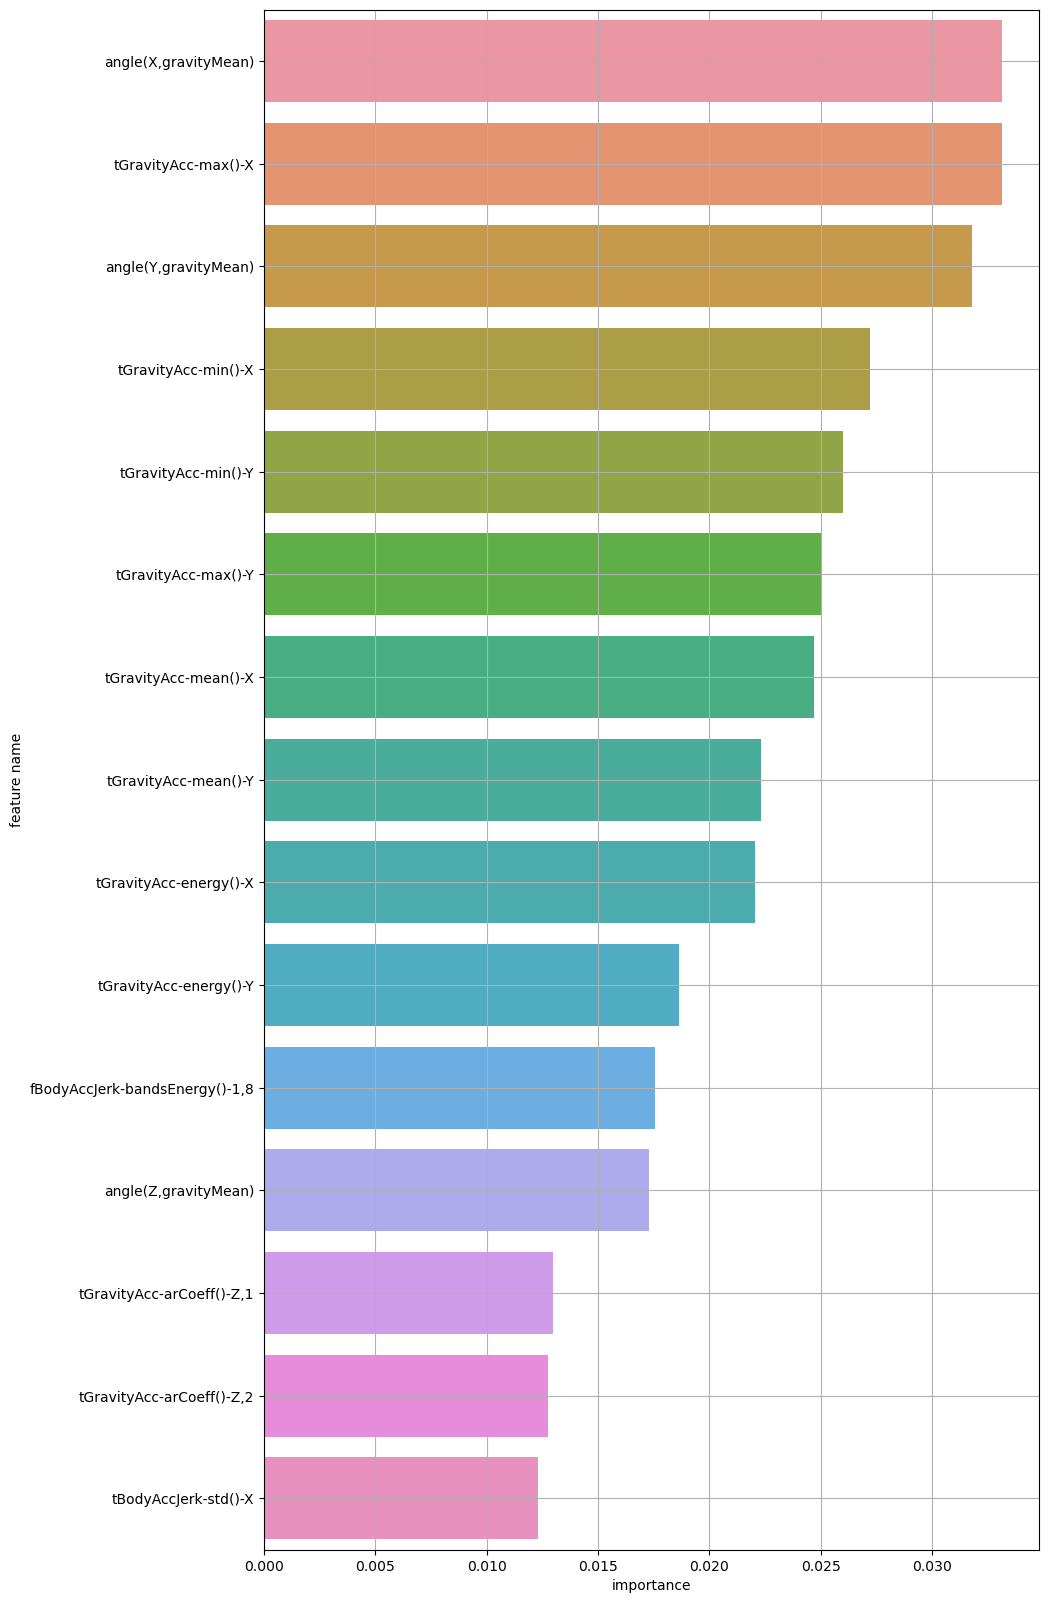

In [21]:
importance = model.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

C:\Users\User\AppData\Local\Temp\ipykernel_14948\3016147516.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data['angle(X,gravityMean)'], shade=True, label='angle(X,gravityMean)')
C:\Users\User\AppData\Local\Temp\ipykernel_14948\3016147516.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data['tGravityAcc-max()-X'], shade=True, label='tGravityAcc-max()-X')
C:\Users\User\AppData\Local\Temp\ipykernel_14948\3016147516.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data['angle(Y,gravityMean)'], shade=True, label='angle(Y,gravityMean)')
C:\Users\User\AppData\Local\Temp\ipykernel_14948\3016147516.py:

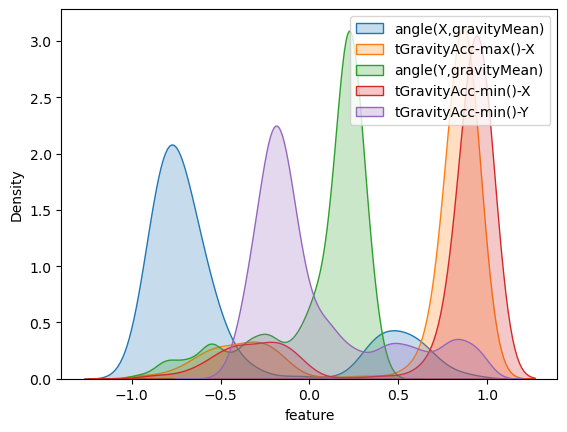

In [22]:
# KDE plot 그리기
sns.kdeplot(data=data['angle(X,gravityMean)'], shade=True, label='angle(X,gravityMean)')
sns.kdeplot(data=data['tGravityAcc-max()-X'], shade=True, label='tGravityAcc-max()-X')
sns.kdeplot(data=data['angle(Y,gravityMean)'], shade=True, label='angle(Y,gravityMean)')
sns.kdeplot(data=data['tGravityAcc-min()-X'], shade=True, label='tGravityAcc-min()-X')
sns.kdeplot(data=data['tGravityAcc-min()-Y'], shade=True, label='tGravityAcc-min()-Y')

# 범례 표시
plt.legend()
plt.xlabel('feature')
# 그래프 보이기
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


In [119]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_Activity'] = model.feature_importances_
df_import.sort_values(by='importance_Activity', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_Activity
558,"angle(X,gravityMean)",0.033154
49,tGravityAcc-max()-X,0.033131
559,"angle(Y,gravityMean)",0.031791
52,tGravityAcc-min()-X,0.027224
53,tGravityAcc-min()-Y,0.025998


In [120]:
result = pd.merge(features, df_import)
result.head()

,sensor,agg,axis,feature_name,importance_Activity
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000039
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000024
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007239
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000100


In [121]:
result.groupby(['sensor'])[['importance_Activity']].sum().sort_values('importance_Activity', ascending=False).head(5)

,importance_Activity
sensor,
tGravityAcc,0.348570
fBodyAccJerk,0.123558
fBodyAcc,0.100767
angle,0.082517
tBodyAccJerk,0.067453


In [122]:
result.groupby(['sensor', 'agg'])[['importance_Activity']].sum().sort_values('importance_Activity', ascending=False).head(5)

importance_Activity
sensor       agg                               
tGravityAcc  arCoeff()                 0.081062
             max()                     0.067139
             min()                     0.062436
fBodyAccJerk bandsEnergy()             0.061579
tGravityAcc  mean()                    0.058701

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [27]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [28]:
# is_dynamic = 
label_change = {'STANDING' : 0,
                'SITTING' : 0,
                'LAYING' : 0,
                'WALKING' : 1,
                'WALKING_UPSTAIRS' : 1,
                'WALKING_DOWNSTAIRS' : 1
               }

data['is_dynamic'] = data['Activity'].map(label_change)
data = data.drop('Activity', axis=1)

In [29]:
target = 'is_dynamic'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

#### 2) 기본모델 생성

In [31]:
model2 = RandomForestClassifier(max_depth=5,
                               random_state=1)

In [32]:
model2.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [33]:
y_pred = model2.predict(x_val)

In [34]:
# 5단계: 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[952   2]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



#### 3) 변수중요도 상위 5개 분석

,feature_name,feature_importance
0,"fBodyAccJerk-bandsEnergy()-1,8",0.060137
1,fBodyAccJerk-entropy()-X,0.059936
2,tBodyAccJerk-energy()-X,0.049941
3,fBodyAccJerk-std()-X,0.040195
4,fBodyAcc-mean()-X,0.039814


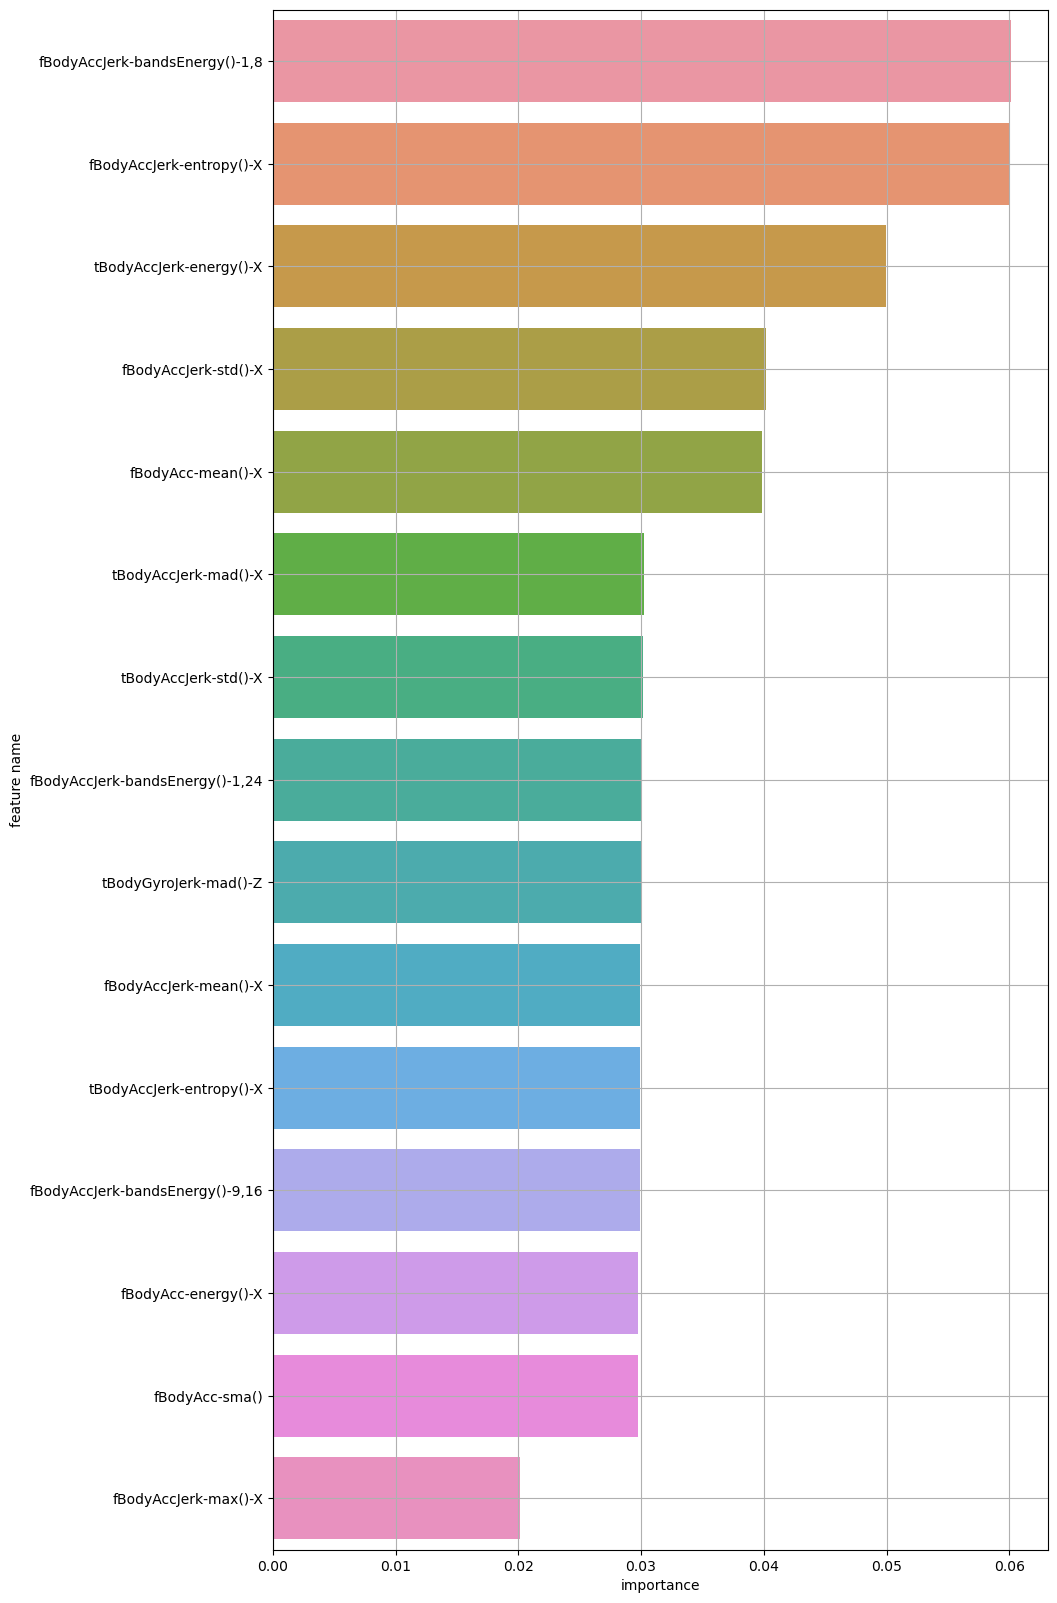

In [35]:
importance = model2.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

#### 4) feature 그룹별 분석

In [123]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_dynamic'] = model2.feature_importances_
df_import.sort_values(by='importance_is_dynamic', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_dynamic
381,"fBodyAccJerk-bandsEnergy()-1,8",0.060137
366,fBodyAccJerk-entropy()-X,0.059936
96,tBodyAccJerk-energy()-X,0.049941
347,fBodyAccJerk-std()-X,0.040195
265,fBodyAcc-mean()-X,0.039814


In [124]:
result2 = pd.merge(features, df_import)
result2.head()

,sensor,agg,axis,feature_name,importance_is_dynamic
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000007
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000029
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.009951
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000


In [126]:
result2.groupby(['sensor'])[['importance_is_dynamic']].sum().sort_values('importance_is_dynamic', ascending=False).head(5)

,importance_is_dynamic
sensor,
fBodyAccJerk,0.399925
tBodyAccJerk,0.220161
fBodyAcc,0.149487
tBodyAccJerkMag,0.059891
fBodyGyro,0.049745


In [127]:
result2.groupby(['sensor', 'agg'])[['importance_is_dynamic']].sum().sort_values('importance_is_dynamic', ascending=False).head(5)

importance_is_dynamic
sensor       agg                                 
fBodyAccJerk bandsEnergy()               0.170137
             entropy()                   0.069876
tBodyAccJerk energy()                    0.059863
             entropy()                   0.049892
fBodyAccJerk std()                       0.040312

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [40]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [41]:
data['is_standing'] = data['Activity'].map(lambda x : 1 if x == 'STANDING' else 0)
data = data.drop('Activity', axis=1)

In [42]:
target = 'is_standing'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [43]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

In [44]:
model3 = RandomForestClassifier(max_depth=5,
                               random_state=1)
model3.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [45]:
y_pred = model3.predict(x_val)

In [46]:
# 5단계: 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1413   21]
 [  32  299]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1434
           1       0.93      0.90      0.92       331

    accuracy                           0.97      1765
   macro avg       0.96      0.94      0.95      1765
weighted avg       0.97      0.97      0.97      1765



,feature_name,feature_importance
0,"angle(Y,gravityMean)",0.071022
1,tGravityAcc-min()-Y,0.065082
2,tGravityAcc-mean()-Y,0.056703
3,tGravityAcc-max()-Y,0.053089
4,"angle(Z,gravityMean)",0.047856


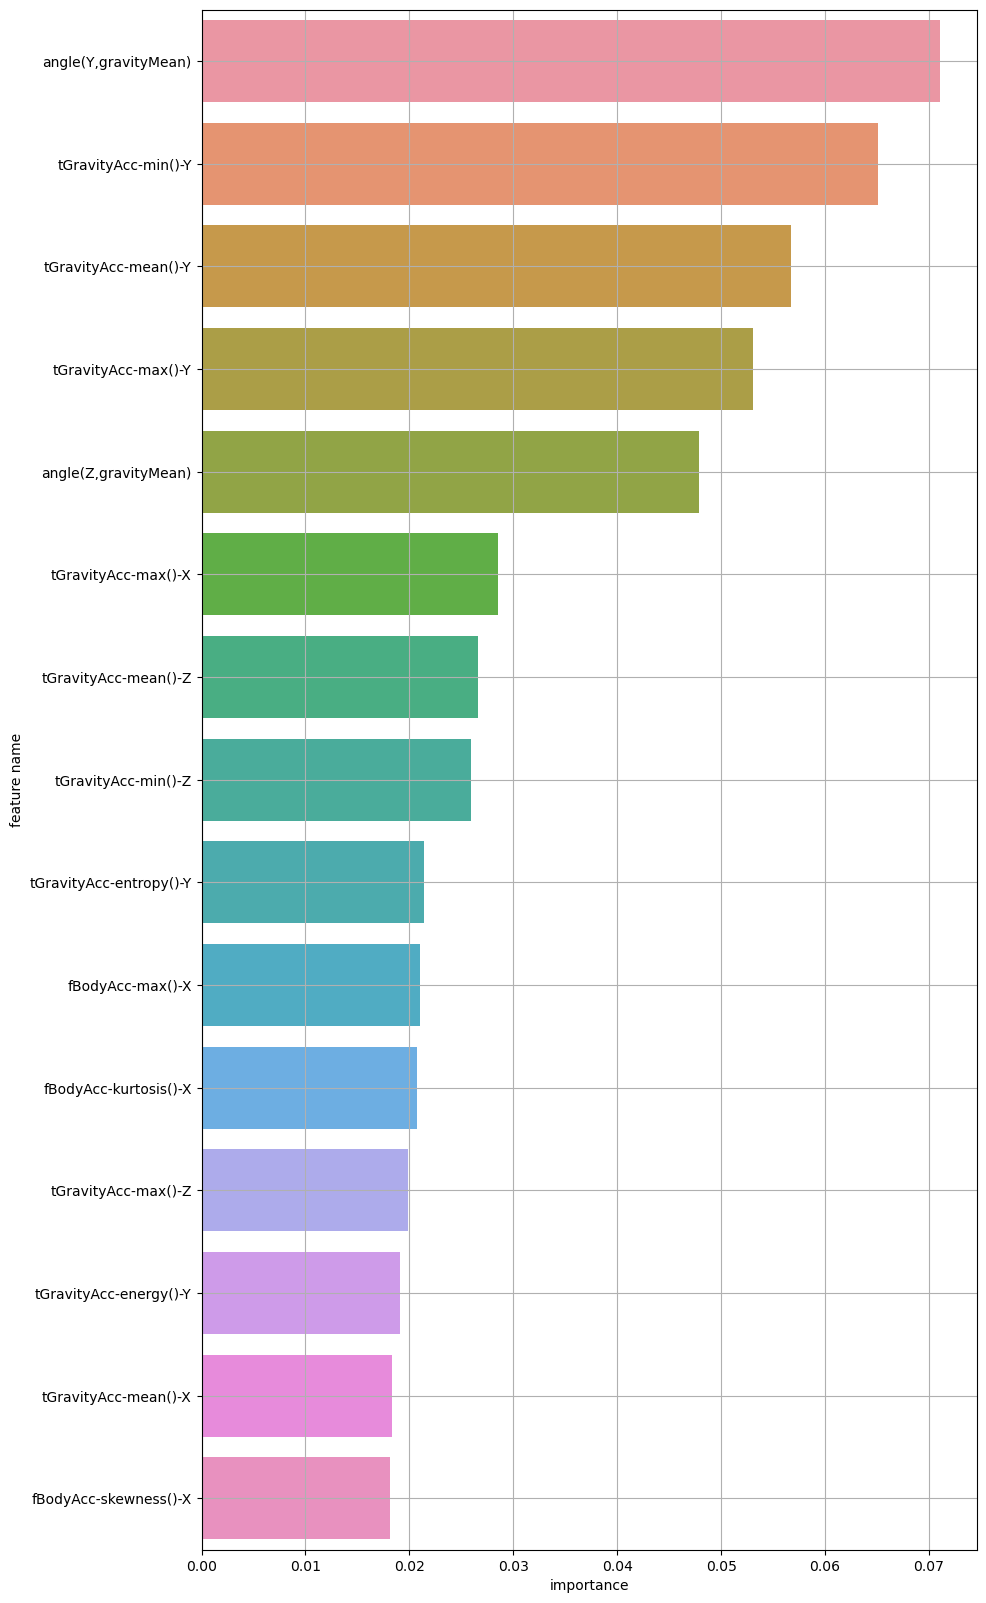

In [47]:
importance = model3.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

In [128]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_standing'] = model3.feature_importances_
df_import.sort_values(by='importance_is_standing', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_standing
559,"angle(Y,gravityMean)",0.071022
53,tGravityAcc-min()-Y,0.065082
41,tGravityAcc-mean()-Y,0.056703
50,tGravityAcc-max()-Y,0.053089
560,"angle(Z,gravityMean)",0.047856


In [129]:
result3 = pd.merge(features, df_import)
result3.head()

,sensor,agg,axis,feature_name,importance_is_standing
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000223
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000034
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.006519
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.001385


In [130]:
result3.groupby(['sensor'])[['importance_is_standing']].sum().sort_values('importance_is_standing', ascending=False).head(5)

,importance_is_standing
sensor,
tGravityAcc,0.432462
fBodyAcc,0.151549
angle,0.130301
fBodyGyro,0.057731
tBodyGyro,0.047325


In [131]:
result3.groupby(['sensor','agg'])[['importance_is_standing']].sum().sort_values('importance_is_standing', ascending=False).head(5)

importance_is_standing
sensor      agg                             
tGravityAcc min()                   0.108641
            mean()                  0.101694
            max()                   0.101487
angle       Y                       0.071022
tGravityAcc energy()                0.053267

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [54]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [55]:
data['is_sitting'] = data['Activity'].map(lambda x : 1 if x == 'SITTING' else 0)
data = data.drop('Activity', axis=1)

In [56]:
target = 'is_sitting'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [57]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

In [58]:
model4 = RandomForestClassifier(max_depth=5,
                               random_state=1)
model4.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [59]:
y_pred = model4.predict(x_val)

In [60]:
# 5단계: 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1454   19]
 [  27  265]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1473
           1       0.93      0.91      0.92       292

    accuracy                           0.97      1765
   macro avg       0.96      0.95      0.95      1765
weighted avg       0.97      0.97      0.97      1765



,feature_name,feature_importance
0,"angle(Y,gravityMean)",0.057355
1,tGravityAcc-min()-Y,0.056865
2,tGravityAcc-max()-Y,0.053994
3,tGravityAcc-max()-X,0.039251
4,tGravityAcc-mean()-Y,0.034306


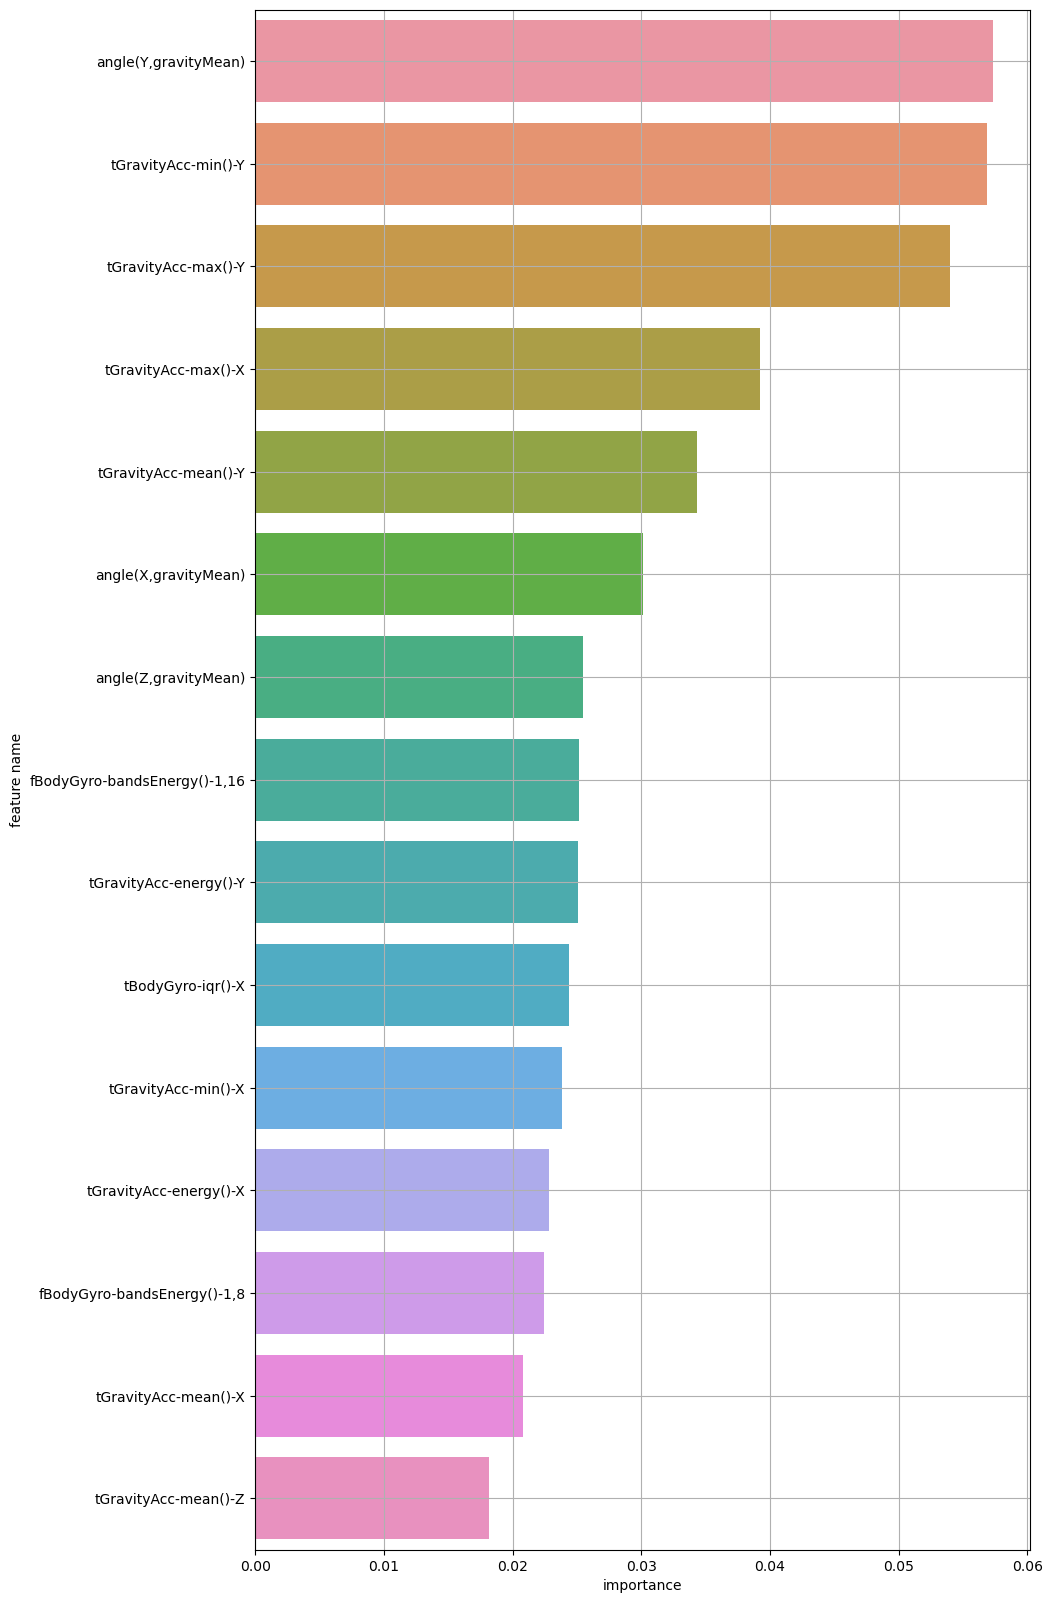

In [61]:
importance = model4.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

In [132]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_sitting'] = model4.feature_importances_
df_import.sort_values(by='importance_is_sitting', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_sitting
559,"angle(Y,gravityMean)",0.057355
53,tGravityAcc-min()-Y,0.056865
50,tGravityAcc-max()-Y,0.053994
49,tGravityAcc-max()-X,0.039251
41,tGravityAcc-mean()-Y,0.034306


In [133]:
result4 = pd.merge(features, df_import)
result4.head()

,sensor,agg,axis,feature_name,importance_is_sitting
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000105
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000061
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.001050
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000237


In [134]:
result4.groupby(['sensor'])[['importance_is_sitting']].sum().sort_values('importance_is_sitting', ascending=False).head(5)

,importance_is_sitting
sensor,
tGravityAcc,0.369134
fBodyGyro,0.365127
angle,0.114609
tBodyGyro,0.085937
tBodyGyroJerk,0.071045


In [135]:
result4.groupby(['sensor', 'agg'])[['importance_is_sitting']].sum().sort_values('importance_is_sitting', ascending=False).head(5)

importance_is_sitting
sensor      agg                                 
fBodyGyro   bandsEnergy()               0.258587
tGravityAcc max()                       0.106990
            min()                       0.090057
            mean()                      0.073281
            energy()                    0.065255

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [66]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [67]:
data['is_laying'] = data['Activity'].map(lambda x : 1 if x == 'LAYING' else 0)
data = data.drop('Activity', axis=1)

In [68]:
target = 'is_laying'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [69]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

In [70]:
model5 = RandomForestClassifier(max_depth=5,
                               random_state=1)
model5.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [72]:
y_pred = model5.predict(x_val)

In [73]:
# 5단계: 평가하기
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1434    0]
 [   0  331]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1434
           1       1.00      1.00      1.00       331

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



,feature_name,feature_importance
0,"angle(X,gravityMean)",0.087108
1,"angle(Y,gravityMean)",0.079351
2,tGravityAcc-min()-X,0.076732
3,tGravityAcc-energy()-X,0.071674
4,tGravityAcc-max()-X,0.061751


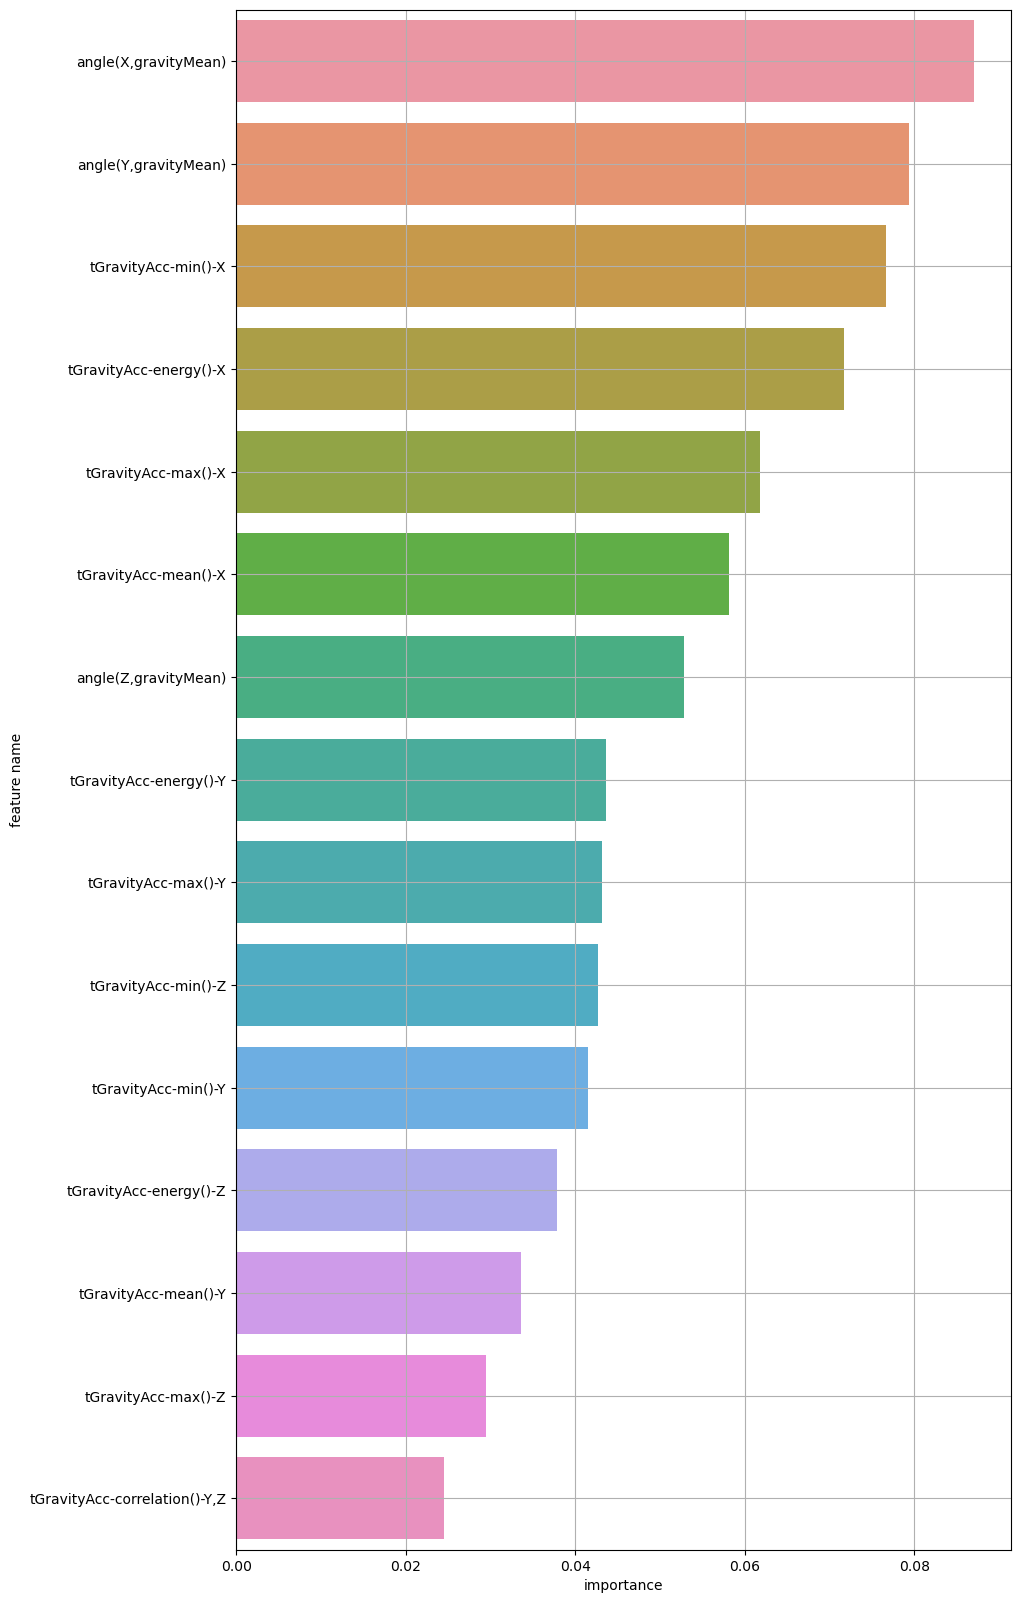

In [74]:
importance = model5.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

In [136]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_laying'] = model5.feature_importances_
df_import.sort_values(by='importance_is_laying', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_laying
558,"angle(X,gravityMean)",0.087108
559,"angle(Y,gravityMean)",0.079351
52,tGravityAcc-min()-X,0.076732
56,tGravityAcc-energy()-X,0.071674
49,tGravityAcc-max()-X,0.061751


In [137]:
result5 = pd.merge(features, df_import)
result5.head()

,sensor,agg,axis,feature_name,importance_is_laying
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000002
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.001302
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000


In [138]:
result5.groupby(['sensor'])[['importance_is_laying']].sum().sort_values('importance_is_laying', ascending=False).head(5)

,importance_is_laying
sensor,
tGravityAcc,0.612960
angle,0.219450
tBodyGyro,0.038321
fBodyAccJerk,0.023282
fBodyAcc,0.022764


In [139]:
result5.groupby(['sensor', 'agg'])[['importance_is_laying']].sum().sort_values('importance_is_laying', ascending=False).head(5)

importance_is_laying
sensor      agg                           
tGravityAcc min()                 0.160991
            energy()              0.153130
            max()                 0.134329
            mean()                0.113102
angle       X                     0.087108

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [79]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [80]:
data['is_walking'] = data['Activity'].map(lambda x : 1 if x == 'WALKING' else 0)
data = data.drop('Activity', axis=1)

In [81]:
target = 'is_walking'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [82]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

In [83]:
model6 = RandomForestClassifier(max_depth=5,
                               random_state=1)
model6.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [84]:
y_pred = model6.predict(x_val)

In [85]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1468    0]
 [  12  285]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1468
           1       1.00      0.96      0.98       297

    accuracy                           0.99      1765
   macro avg       1.00      0.98      0.99      1765
weighted avg       0.99      0.99      0.99      1765



,feature_name,feature_importance
0,"tBodyAcc-correlation()-X,Y",0.032466
1,"fBodyAcc-bandsEnergy()-1,8",0.025902
2,tBodyGyroJerk-mad()-X,0.024719
3,"fBodyAcc-bandsEnergy()-1,16",0.023556
4,"fBodyGyro-bandsEnergy()-17,24",0.022039


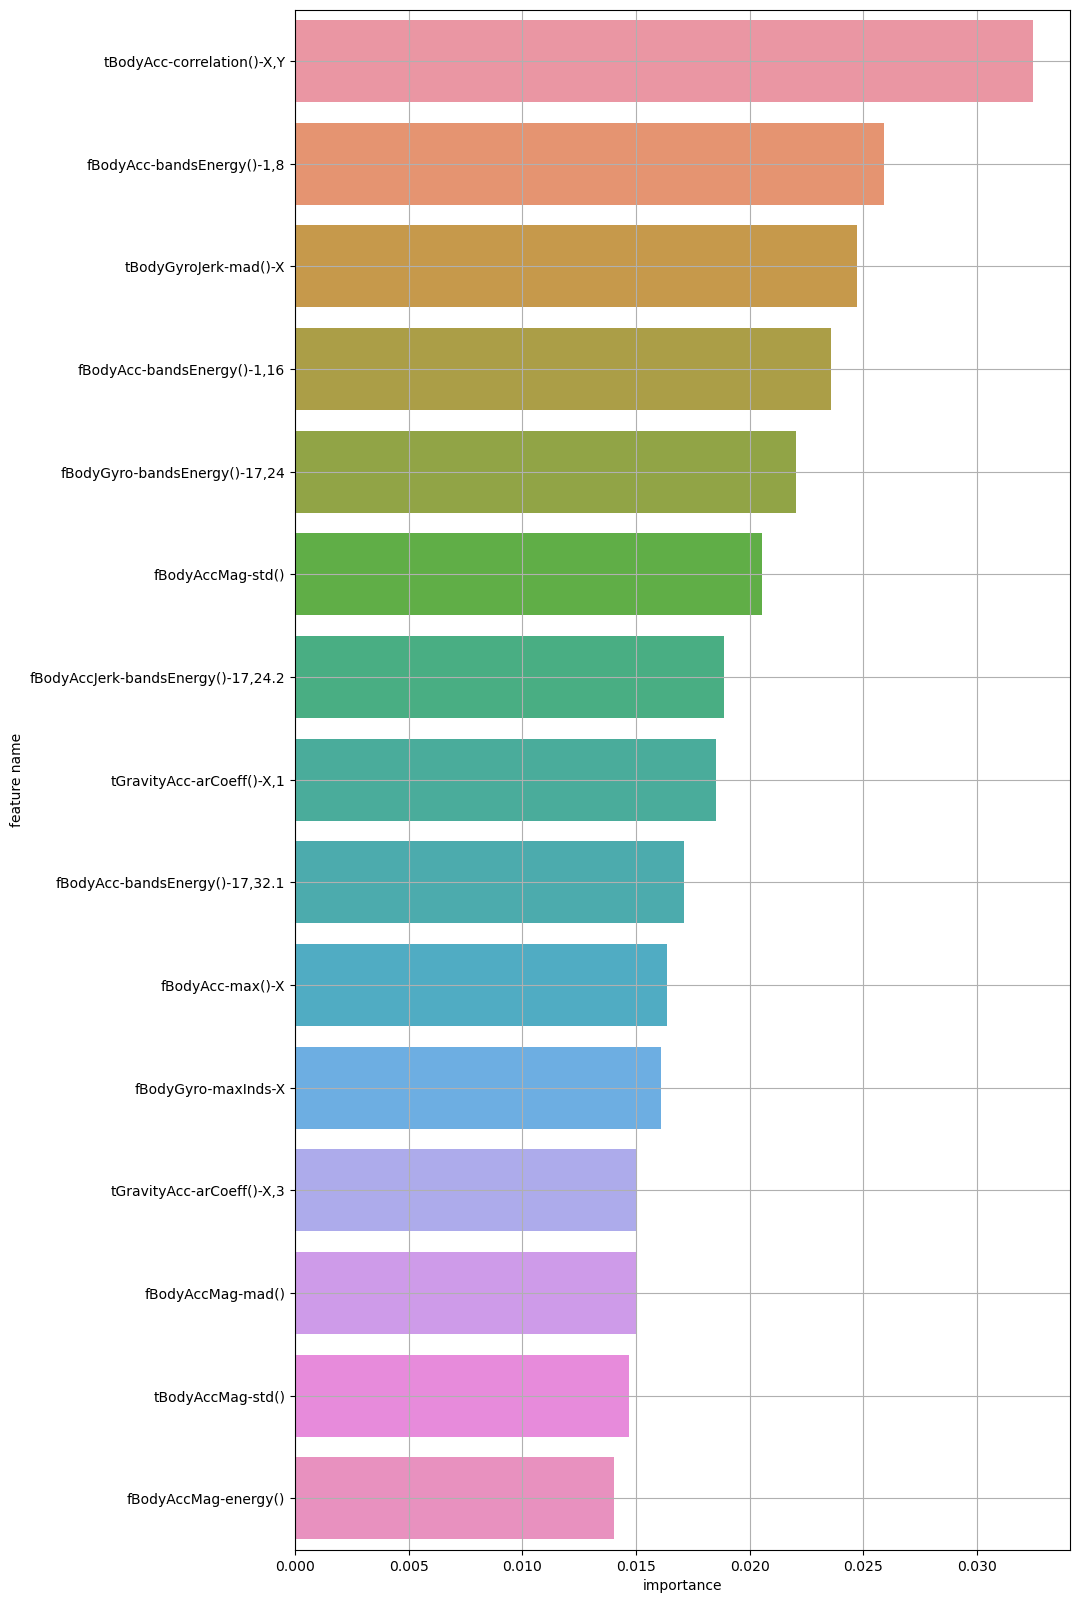

In [86]:
importance = model6.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

In [140]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_walking'] = model6.feature_importances_
df_import.sort_values(by='importance_is_walking', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_walking
37,"tBodyAcc-correlation()-X,Y",0.032466
302,"fBodyAcc-bandsEnergy()-1,8",0.025902
166,tBodyGyroJerk-mad()-X,0.024719
310,"fBodyAcc-bandsEnergy()-1,16",0.023556
462,"fBodyGyro-bandsEnergy()-17,24",0.022039


In [141]:
result6 = pd.merge(features, df_import)
result6.head()

,sensor,agg,axis,feature_name,importance_is_walking
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000200
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.003624
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000174


In [142]:
result6.groupby(['sensor'])[['importance_is_walking']].sum().sort_values('importance_is_walking', ascending=False).head(5)

,importance_is_walking
sensor,
fBodyGyro,0.164550
fBodyAcc,0.147257
tGravityAcc,0.126184
fBodyAccJerk,0.116426
tBodyGyroJerk,0.089449


In [143]:
result6.groupby(['sensor', 'agg'])[['importance_is_walking']].sum().sort_values('importance_is_walking', ascending=False).head(5)

,,importance_is_walking
sensor,agg,
fBodyGyro,bandsEnergy(),0.134478
fBodyAcc,bandsEnergy(),0.096445
tGravityAcc,arCoeff(),0.085588
fBodyAccJerk,bandsEnergy(),0.077181
tBodyAcc,correlation(),0.033324


### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [91]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [92]:
data['is_walking_up'] = data['Activity'].map(lambda x : 1 if x == 'WALKING_UPSTAIRS' else 0)
data = data.drop('Activity', axis=1)

In [93]:
target = 'is_walking_up'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [94]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

In [95]:
model7 = RandomForestClassifier(max_depth=5,
                               random_state=1)
model7.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [97]:
y_pred = model7.predict(x_val)

In [98]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1484    6]
 [  12  263]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1490
           1       0.98      0.96      0.97       275

    accuracy                           0.99      1765
   macro avg       0.98      0.98      0.98      1765
weighted avg       0.99      0.99      0.99      1765



,feature_name,feature_importance
0,tGravityAcc-min()-Y,0.046200
1,"tGravityAcc-arCoeff()-Z,1",0.044526
2,"tGravityAcc-arCoeff()-Z,3",0.038238
3,"angle(Y,gravityMean)",0.033538
4,fBodyAccJerk-maxInds-Z,0.024940


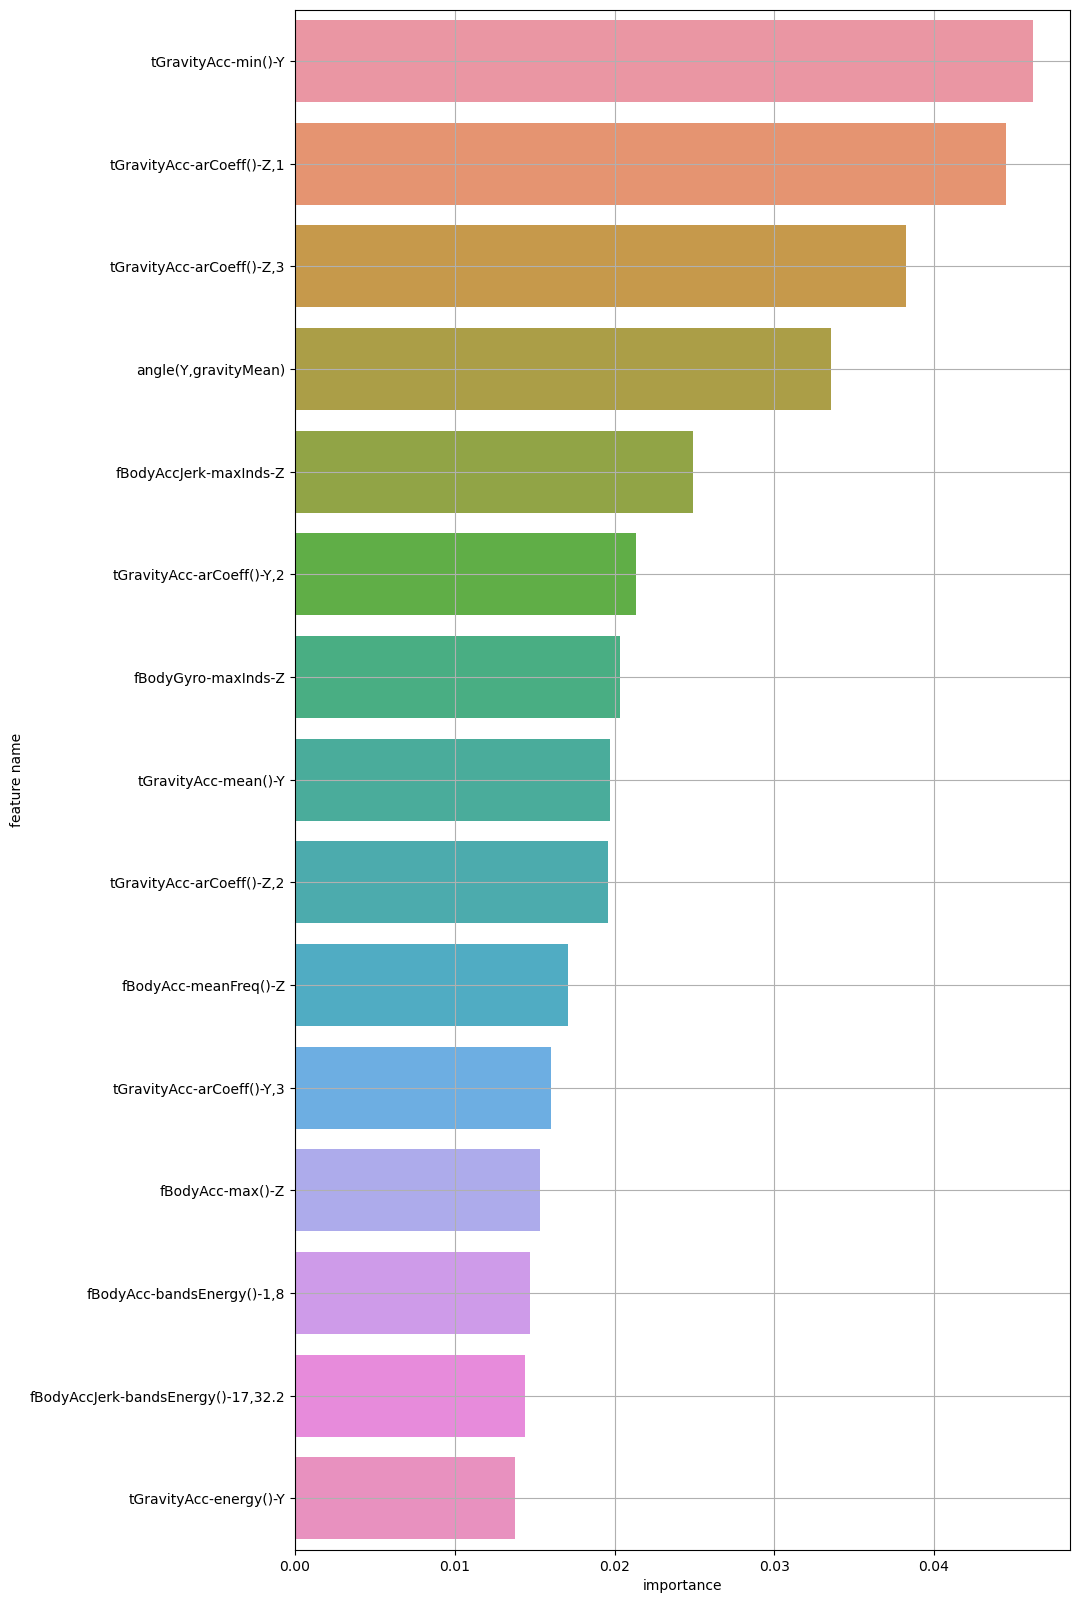

In [99]:
importance = model7.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

In [144]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_walking_up'] = model7.feature_importances_
df_import.sort_values(by='importance_is_walking_up', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_walking_up
53,tGravityAcc-min()-Y,0.046200
73,"tGravityAcc-arCoeff()-Z,1",0.044526
75,"tGravityAcc-arCoeff()-Z,3",0.038238
559,"angle(Y,gravityMean)",0.033538
371,fBodyAccJerk-maxInds-Z,0.024940


In [145]:
result7 = pd.merge(features, df_import)
result7.head()

,sensor,agg,axis,feature_name,importance_is_walking_up
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000129
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000343
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000048
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.005212
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000039


In [146]:
result7.groupby(['sensor'])[['importance_is_walking_up']].sum().sort_values('importance_is_walking_up', ascending=False).head(5)

,importance_is_walking_up
sensor,
tGravityAcc,0.303123
fBodyAcc,0.208390
fBodyAccJerk,0.115718
tBodyAccJerk,0.050543
fBodyGyro,0.047723


In [147]:
result7.groupby(['sensor', 'agg'])[['importance_is_walking_up']].sum().sort_values('importance_is_walking_up', ascending=False).head(5)

,,importance_is_walking_up
sensor,agg,
tGravityAcc,arCoeff(),0.175824
fBodyAcc,bandsEnergy(),0.088847
tGravityAcc,min(),0.055012
fBodyAccJerk,bandsEnergy(),0.053488
fBodyAcc,max(),0.035102


### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [104]:
data = pd.read_csv("data01_train.csv")
features = pd.read_csv("features.csv")

In [105]:
data['is_walking_down'] = data['Activity'].map(lambda x : 1 if x == 'WALKING_DOWNSTAIRS' else 0)
data = data.drop('Activity', axis=1)

In [106]:
target = 'is_walking_down'
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [107]:
x_train, x_val, y_train, y_val = train_test_split(x, y,
                                                 test_size =.3,
                                                 random_state = 1)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((4116, 562), (4116,), (1765, 562), (1765,))

In [108]:
model8 = RandomForestClassifier(max_depth=5,
                               random_state=1)
model8.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

In [109]:
y_pred = model8.predict(x_val)

In [110]:
print(confusion_matrix(y_val, y_pred))
print(classification_report(y_val, y_pred))

[[1516   10]
 [  28  211]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1526
           1       0.95      0.88      0.92       239

    accuracy                           0.98      1765
   macro avg       0.97      0.94      0.95      1765
weighted avg       0.98      0.98      0.98      1765



,feature_name,feature_importance
0,fBodyAcc-energy()-X,0.049970
1,tGravityAccMag-std(),0.042007
2,fBodyAccMag-mad(),0.038832
3,fBodyAccMag-energy(),0.035445
4,fBodyAccMag-std(),0.034874


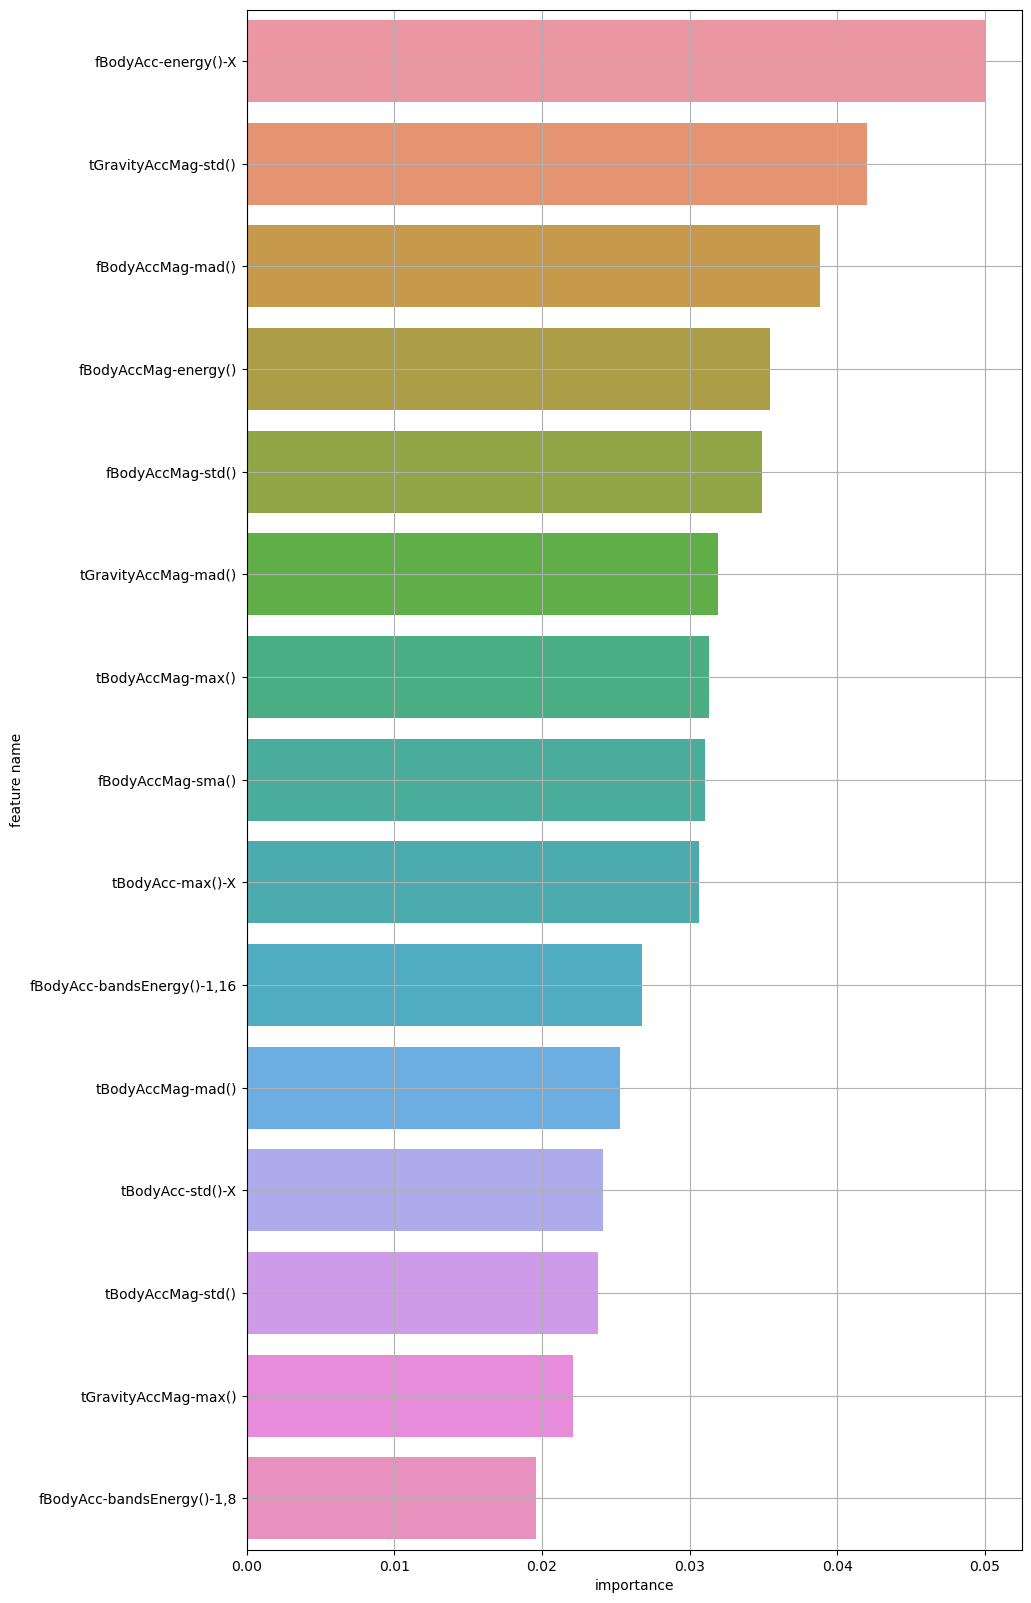

In [111]:
importance = model8.feature_importances_
names = list(x)
plot_feature_importance(importance, names)

In [148]:
df_import = pd.DataFrame()
df_import['feature_name'] = list(x)
df_import['importance_is_walking_down'] = model8.feature_importances_
df_import.sort_values(by='importance_is_walking_down', ascending=False, inplace=True)

df_import.head()

,feature_name,importance_is_walking_down
281,fBodyAcc-energy()-X,0.049970
214,tGravityAccMag-std(),0.042007
504,fBodyAccMag-mad(),0.038832
508,fBodyAccMag-energy(),0.035445
503,fBodyAccMag-std(),0.034874


In [149]:
result8 = pd.merge(features, df_import)
result8.head()

,sensor,agg,axis,feature_name,importance_is_walking_down
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000118
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000018
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.024136
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.002025


In [150]:
result8.groupby(['sensor'])[['importance_is_walking_down']].sum().sort_values('importance_is_walking_down', ascending=False).head(5)

,importance_is_walking_down
sensor,
fBodyAcc,0.198663
fBodyAccMag,0.191833
tGravityAccMag,0.132652
tBodyAccMag,0.106839
tBodyAcc,0.099250


In [152]:
result8.groupby(['sensor', 'agg'])[['importance_is_walking_down']].sum().sort_values('importance_is_walking_down', ascending=False).head(5)

importance_is_walking_down
sensor         agg                                      
fBodyAcc       bandsEnergy()                    0.077200
               energy()                         0.051380
fBodyAccJerk   bandsEnergy()                    0.044357
tGravityAccMag std()                            0.042007
fBodyAccMag    mad()                            0.038832

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

In [159]:
df =  pd.merge(result, result2)
df =  pd.merge(df, result3)
df =  pd.merge(df, result4)
df =  pd.merge(df, result5)
df =  pd.merge(df, result6)
df =  pd.merge(df, result7)
df =  pd.merge(df, result8)

In [161]:
df

,sensor,agg,axis,feature_name,importance_Activity,importance_is_dynamic,importance_is_standing,importance_is_sitting,importance_is_laying,importance_is_walking,importance_is_walking_up,importance_is_walking_down
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000039,0.000000,0.000000,0.000000,0.000002,0.000200,0.000129,0.000118
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000,0.000007,0.000223,0.000105,0.000000,0.000000,0.000343,0.000018
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000024,0.000029,0.000034,0.000061,0.000000,0.000000,0.000048,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007239,0.009951,0.006519,0.001050,0.001302,0.003624,0.005212,0.024136
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000100,0.000000,0.001385,0.000237,0.000000,0.000174,0.000039,0.002025
...,...,...,...,...,...,...,...,...,...,...,...,...
92368,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000000,0.000000,0.000461,0.000083,0.000000,0.000249,0.000000,0.000031
92369,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000270,0.000000,0.001285,0.001289,0.000110,0.000037,0.000042,0.000000
92370,angle,X,gravityMean,"angle(X,gravityMean)",0.033154,0.000010,0.009604,0.030141,0.087108,0.002155,0.004752,0.001513
92371,angle,Y,gravityMean,"angle(Y,gravityMean)",0.031791,0.000059,0.071022,0.057355,0.079351,0.003595,0.033538,0.003585


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [169]:
# 데이터 저장
df.to_pickle('filename.pkl')